## Long-term and Short-term Memory for LLM Agents

Memory in AI Applications referes to the ability to process, store, and effectively recall information from past interactions. With memory, our agents can learn from feedback and adapt to user's preferences. Here we explain the two types of memory that a real life AI app will need. 

1. Short-Term Memory: or threaded-scoped memory, can be recalled at any time from within a single conversational thread with a user. 
2. Long-Term Memory: it is shared across conversational threads. It can be recalled at any time a


### Short-Term Memory
Langgraph manages short-term memory as part of your agent's state. State is persisted to a database using a checkpointer so the thread can be resumed any time. Short-term memory updates when the graph is invoked or a step is completedm and the State is read at the start of each step. To give you more context, Langgraph has a built-in persistence layer, implemented through checkpointers. When you compile graph with a checkpointer, the checkpointer saves a `checkpoint` of the graph state at every super-step. Those checkpoints are saved to a `thread`, which can be accessed after graph execution. 

#### Threads
A thread is a unique ID assigned to each checkpoint saved by a checkpointer. When invoking the graph with the checkpointer, we must specify a thread_id as part of the configurable portion of the config.

#### Checkpoints
Checkpoint is a snapshot of the graph state saved at each super-step and is represented by `StateSnapshot` object with the following key properties:

* `config`: Config associated with this checkpoint
* `metadata`: Metadata associated with this checkpoint
* `values`: Values of the state channels at this point in time
* `next`: A tuple of the nodenames to execute next in the graph
* `tasks`: A tuple of `PregelTask` objects that contain information about next steps to be executed. 

### Long-Term Memory

It is shared across conversational threads. It can be recalled at any time and in any thread. Memories are scoped to any custom namesapce, not just within a single thread ID. LangGraph provides stores to let you save the recall long-term memories. 



In [ ]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.prebuilt import create_react_agent
from langchain.vectorstores import FAISS
from langchain.document_loaders import PyPDFLoader
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnablePassthrough, RunnableConfig
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.messages import HumanMessage, get_buffer_string
from langchain_core.vectorstores import InMemoryVectorStore 
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import create_react_agent, ToolNode
from langgraph.checkpoint.memory import MemorySaver
from typing import Dict
from config import Settings
import os
import tiktoken
import uuid
from pydantic import BaseModel, Field
import operator
from typing import Annotated, List, Tuple, Union
from typing_extensions import TypedDict

### Define OpenAI Models

In [18]:
api_key = Settings.api_key
VECTOR_DIR = 'vectorize'
embeddings = OpenAIEmbeddings(
    model="text-embedding-ada-002",
    api_key=api_key)

In [19]:
llm = ChatOpenAI(model="gpt-4o", api_key=api_key)

SYSTEM_TEMPLATE = """
    Answer the user's questions based on the below context. 
    If the context doesn't contain any relevant information to the questions, don't make someting up
    and just reply information cannot be fount:
    <context>
    {context}
    </context>
    """

### Define Tools

We first define the vectorstore where we will be storing our memories. Memories will be stored as embeddings and later looked up based on the converstation context. We are using an in-memory vectorstore. 

In [20]:
recall_vector_store = InMemoryVectorStore(embeddings)

def get_user_id(config: RunnableConfig) -> str:

    user_id = config["configurable"].get("user_id")
    if user_id in None:
        raise ValueError("User ID needs to be provided to save memory")
    return user_id

@tool
def save_recall_memory(memory: str, config: RunnableConfig) -> str:

    "Save memory to vectorstore for later semantic search retrieval."
    user_id = get_user_id(config)
    document = Document(page_content=memory, id=str(uuid.uuid4()), metadata={"user_id": user_id})
    recall_vector_store.add_document([document])

@tool
def search_recall_memories(query: str, config: RunnableConfig) -> List[str]:
    """Search for relevant memories."""

    user_id = get_user_id(config)

    def _filter_function(doc: Document) -> bool:
        return doc.metadata.get("user_id") == user_id

    documents = recall_vector_store.similarity_search(query, k=3, filter=_filter_function)
    return [document.page_content for document in documents]


In [21]:
def parse_retriever_input(params: Dict):
    return params["messages"][-1].content


@tool
def contextualQA(earnings_question: str, company_name: str) -> str:

    """
    Identifies the relevant context in the earning call transcripts to the user question

    This tool searches in the earnings calls transcript documents and extract financial information
    such as net income, REvenue, EBITDA and etc.

    Parameters:
    - earnings_question: The questions asked by the user
    - the company for which we need to answer the question. Company names should always be lowercase

    Returns:
    - A string with the context that contain the answer to the earnings question.
    """
    vector_store = FAISS.load_local(VECTOR_DIR + "/" + company_name, 
                                    embeddings, 
                                    allow_dangerous_deserialization=True)
    retriever = vector_store.as_retriever()
    qa_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", SYSTEM_TEMPLATE),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    qa_chain = create_stuff_documents_chain(llm, qa_prompt)
    retrieval_chain = RunnablePassthrough.assign(
    context = parse_retriever_input | retriever).assign(answer=qa_chain)
    response = retrieval_chain.invoke(
        {
            "messages": [HumanMessage(content=earnings_question)]
        }
    )
    return response["answer"]


In [22]:
tools = [save_recall_memory, search_recall_memories, contextualQA]

In [23]:
class State(MessagesState):
    # Add memories that will be retrieved based on the conversation context
    recall_memories: List[str]

In [24]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant with advanced long-term memory"
     "capabilities and ability to search in earnings call document and retrieve company financial fundamentals such as total revenue"
     "expenses and costs, EBITDA and etc. Powered by stateless LLM, you must rely on external memory to store"
     "information between conversations. Utilize the available memory tools to store and retrieve important details"
     "that will help you better attend to user's needs and understand their context and understand their context. \n\n"
     "Memory Usage Guidelines: \n"
     "1. Actively use memory tools (save_recall_memory, search_recall_memories) to build a comprehensive understanding of the user. \n"
     "2. Actively use memory tools (save_recall_memory, search_recall_memories) to store and retrieve  all the financial data users are interested in. \n"
     "3. Make informed suppositions and extrapolations based on stored memories \n\n"
     "## Recall Memories \n"
     "Recall memories are contextually retrieved based on the current conversations: \n{recall_memories}\nn"
     "Earning Calls Documents search and Retrieval Guidelines: \n\n"
     "1. Actively use search tool contextualQA to search and identify financial information for a particular company requested by a user \n"
     "2. Actively use memory tools (save_recall_memory, search_recall_memories) to build a comprehensive understanding of the user request on earnings calls information"
    ),
    ("placeholder", "{messages}")
]
)

In [27]:
model_with_tools = llm.bind_tools(tools)
tokenizer = tiktoken.encoding_for_model("gpt-4o")

In [31]:
def agent(state: State) -> State:
    """Process the current state and generate a response using the LLM.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        schemas.State: The updated state with the agent's response.
    """
    bound = prompt | model_with_tools
    recall_str = (
        "<recall_memory>\n" + "\n".join(state["recall_memories"]) + "\n</recall_memory>"
    )
    prediction = bound.invoke(
        {
            "messages": state["messages"],
            "recall_memories": recall_str,
        }
    )
    return {
        "messages": [prediction],
    }

def load_memories(state: State, config: RunnableConfig) -> State:

    """
    Load memories for the current conversation

    Args:
        state (schemas.State): The current state of the conversation
        config (RunnableConfig): The runtime configuration for the agent

    Returns:
        State: The updated state with loaded memories.
    """
    convo_str = get_buffer_string(state["messages"])
    convo_str = tokenizer.decode(tokenizer.encode(convo_str)[:2048])
    recall_memories = search_recall_memories.invoke(convo_str, config)
    return {
        "recall_memories": recall_memories,
    }

def route_tools(state: State):
    """
    Determine wether to use the tools or end the conversation based on the last message.

    Args:
       state (schemas.State): The current state of the conversation.

    Returns:
          Literal["tools", "__end__"]: The next step in the graph.
    """
    msg = state["messages"][-1]
    if msg.tool_calls:
        return "tools"
    return END

    

In [34]:
builder = StateGraph(State)
builder.add_node(load_memories)
builder.add_node(agent)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "load_memories")
builder.add_edge("load_memories", "agent")
builder.add_conditional_edges("agent", route_tools, ["tools", END])
builder.add_edge("tools", "agent")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

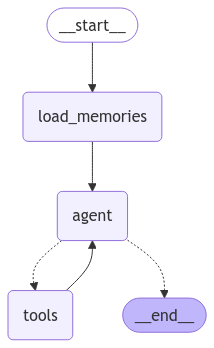

In [35]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
def pretty_print_stream_chunk(chunk):
    for node, updates in chunk.items():
        print(f"Update from node: {node}")
        if "messages" in updates:
            updates["messages"][-1].pretty_print()
        else:
            print(updates)

        print("\n")

In [ ]:
# NOTE: we're specifying `user_id` to save memories for a given user
config = {"configurable": {"user_id": "1", "thread_id": "1"}}

for chunk in graph.stream({"messages": [("user", "my name is John")]}, config=config):
    pretty_print_stream_chunk(chunk)